<a href="https://colab.research.google.com/github/hrishavkmr/TrafficSignRecognition/blob/master/Traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1
**Object Detection API configuration**: In this step, the model for object detection is downloaded, also some copying and deletion of references are done to leave the whole scheme configured.

In [1]:
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Cloning into 'models'...
remote: Enumerating objects: 25600, done.
remote: Total 25600 (delta 0), reused 0 (delta 0), pack-reused 25600
Receiving objects: 100% (25600/25600), 507.99 MiB | 38.68 MiB/s, done.
Resolving deltas: 100% (15357/15357), done.
Checking out files: 100% (2883/2883), done.


In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Step 2

**Imports** needed to run the Object Detection API demonstration

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob
from google.colab.patches import cv2_imshow

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pandas as pd
import random
import cv2

Using TensorFlow backend.


# Step 3
**Configuration** of the model to use, path to the frozen inference graph and extra config elements for the Object detection API implementation.

In [0]:
# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

# model with more accurancy but up to you use a diferent model
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'



In [13]:
!git clone https://github.com/hrishavkmr/gtsdb_data

Cloning into 'gtsdb_data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [0]:
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/drive/My Drive/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('gtsdb_data','gtsdb_label_map.pbtxt')

NUM_CLASSES = 3

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [30]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'gtsdb_data/test_images'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpeg'))

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

In [0]:
from keras.models import load_model
data = pd.read_csv('signnames.csv')

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
  
def equalize(img):
    img = cv2.equalizeHist(img)
    return img# only grayscale images
  
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255 #normalizing the input
    return img

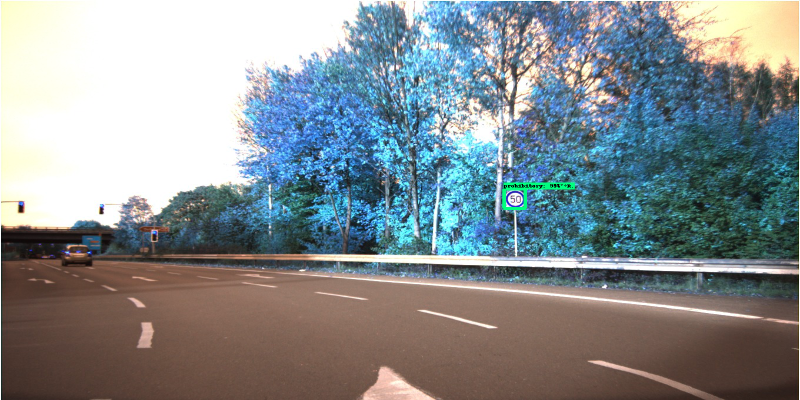

Detected image


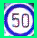

predicted sign index: [2]
Predicted sign: Speed limit (50km/h)


In [44]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            height, width = image_np.shape[:2]
            ymin = int(boxes[0][idx][0]*height)
            xmin = int(boxes[0][idx][1]*width)
            ymax = int(boxes[0][idx][2]*height)
            xmax = int(boxes[0][idx][3]*width)
            imS = cv2.resize(image_np, (800, 400))
            cv2_imshow(imS)
            print('Detected image')
            img = image_np[ymin:ymax,xmin:xmax]
            cv2_imshow(image_np[ymin:ymax,xmin:xmax])
  
            #prediction on detected image
            img =  cv2.resize(img, (32, 32))
            img = preprocessing(img)
            img = img.reshape(1, 32, 32, 1)
            model = load_model('trained_model.h5')
            print("predicted sign index: "+ str(model.predict_classes(img)))
            print("Predicted sign: " + data.iloc[model.predict_classes(img)[0]]['SignName'])